# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №2 - Алгоритмы кластеризации


###### <hr\>
**Общая информация**

**Срок сдачи:** 23 октября 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 23 октября, -4 балла после 06:00 30 октября, -6 баллов после 06:00 6 ноября

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush Необходимо в slack создать таск в приватный чат:
/todo Фамилия Имя ссылка на гитхаб @alkhamush
Пример:
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb @alkhamush

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

###### Задание 1 (4 балла)
Реализовать алгоритм кластеризации, который относится к вашему варианту. Проверить работоспособность алгоритма на "Iris". Сравните свой алгоритм кластеризации с алгоритмом из scikit-learn по времени выполнения, использую timeit. Ваша реализация не должна работать сильно дольше, а в идеале должна быть даже немного быстрее.

###### Задание 2 (2 балла)
Выбрать, имплементировать и использовать критерий качества

###### Задание 3 (3балла)
Применить алгоритм кластеризации к данным по странам.   
Подход следующий: фиксируем год, для каждой страны берём индикаторы по зафиксированному году, кластеризуем по индикаторам.   
Разбиение должно быть объяснимым, в противном случае, скорее всего нужно лучше настроить параметры кластеризации.   
Данные нужно скачать тут https://data.worldbank.org/data-catalog/world-development-indicators.   
Также необходимо показать, какие страны попали в общий кластер.
изуализировать результат с помощью T-SNE. Внимание! На полном объеме данных данный алгоритм может работать существенное время.

###### Задание 4 (1 балл)
Опишите в выводе почему и какие страны попали в общий кластер.

Основная задача этого задания - реализация одного из алгоритмов кластеризации. Кроме того, мы научимся подбирать параметры алгоритма, визуализируем результат кластеризации и попытаемся проанализировать природу полученных кластеров.

In [128]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt
from scipy.spatial import distance
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
#import mpl_toolkits.basemap as bm
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Реализация алгоритма

Алгоритм кластеризации, который необходимо реализовать, выбирается на основании Вашего порядкового номера в списке группы.

1. Авилова Екатерина
2. Адаменко Павел
3. Акиньщиков Алексей
4. Афанасьева Анастасия
5. Балес Александр
6. Беляев Владимир
7. Беспалова Анастасия
8. Богомолов Эмиль
9. Боднарюк Василий
10. Бучкин Александр
11. Валинуров Денис
12. Волков Глеб
13. Голенков Кирилл
14. Горбушин Михаил
15. Димов Илья
16. Докшина Елизавета
17. Дорожинский Владислав
18. Жирнов Михаил
19. Жолковский Евгений
20. Зайдель Петр
21. Зимнюков Максим
22. Иванов Илья
23. Кашипов Артем
24. Комов Евгений
25. Кошман Дима
26. Кузнецова Екатерина
27. Кулагин Алексей
28. Лавреновъ Виталiй
29. Лебедь Федор
30. Лешков Михаил
31. Лозинский Иван
32. Лоскутов Антон
33. Лютов Владимир
34. Мажаров Иван
35. Манкевич Павел
36. Муравьев Никита
37. Находнов Максим
38. Оплачко Николай
39. Павлов Евгений
40. Петряйкин Федор
41. Рахматуллин Фарид
42. Секретарев Тихон
43. Сенюшкин Дмитрий
44. Серов Николай
45. Смирнов Александр
46. Соловьев Павел
47. Сомов Иван
48. Спиркин Роман
49. Терёшина Мария
50. Торбунова Екатерина
51. Тюгаев Антон
52. Фельдман Борис
53. Филин Максим
54. Фролов Михаил
55. Хохлов Олег
56. Черемнов Андрей
57. Шевцов Антон
58. Шурыгин Александр

In [2]:
N = 52 # put your index here

In [3]:
algorithms = [
    u"Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - k)",
    u"Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)",
    u"DBSCAN. (параметры - epsilon, min_pts)"
]

my_algorithm = algorithms[N % len(algorithms)]
print u"Реализуем алгоритм кластеризации '%s'" % my_algorithm

Реализуем алгоритм кластеризации 'Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)'


Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`

In [129]:
## Задание 1
from time import time
from sklearn import datasets

from sklearn.base import BaseEstimator, ClusterMixin

class Clustering(BaseEstimator, ClusterMixin):
   
    def __init__(self, X, k, linkage, **kwargs):
        self.X = X
        self.X_for_average_linkage = X
        self.labels_for_average_linkage = np.array([range(self.X.shape[0]),np.ones(self.X.shape[0])]) 
        self.distance_matrix = self.init_distance_matrix()
        self.linkage = linkage
        self.Z = np.zeros((1,4)) 
        self.cluster_number = self.X.shape[0] - 1
        self.labels_amount = np.array([range(self.X.shape[0]),np.ones(self.X.shape[0])])
        self.k = k
        return
    
    def init_distance_matrix(self): 
        res = ss.distance.cdist(self.X, self.X)
        np.fill_diagonal(res,'inf')
        return res
    
    def update_distance_matrix(self, pair_to_unite):
        if self.linkage == 'average':
            self.distance_matrix[pair_to_unite[0]] = (self.distance_matrix[pair_to_unite[0]] * self.labels_amount[1][pair_to_unite[0]]  + self.distance_matrix[pair_to_unite[1]] * self.labels_amount[1][pair_to_unite[1]]) / ((self.labels_amount[1][pair_to_unite[0]] + self.labels_amount[1][pair_to_unite[1]]))
        else:
            if self.linkage == 'single':
                self.distance_matrix[pair_to_unite[0]] = np.minimum(self.distance_matrix[pair_to_unite[0]],self.distance_matrix[pair_to_unite[1]])              

            else:
                if self.linkage == 'complete':
                    self.distance_matrix[pair_to_unite[0]] = np.maximum(self.distance_matrix[pair_to_unite[0]],self.distance_matrix[pair_to_unite[1]])                    
        self.distance_matrix[:,pair_to_unite[0]] = self.distance_matrix[pair_to_unite[0]]
        np.fill_diagonal(self.distance_matrix,'inf')
        self.distance_matrix = np.delete(self.distance_matrix, pair_to_unite[1], axis=0)
        self.distance_matrix = np.delete(self.distance_matrix, pair_to_unite[1], axis=1)
    def find_closest(self):
        argmin_ = np.argmin(self.distance_matrix)
        col = argmin_ % self.distance_matrix.shape[1]
        row = (argmin_ - col) / self.distance_matrix.shape[1]  
        return row, col
    
    def unite_sets(self, pair_to_unite):
        self.X = np.delete(self.X, pair_to_unite[1],axis=0)
        self.labels_amount = np.delete(self.labels_amount, pair_to_unite[1],axis=1)
        self.labels_amount[1][pair_to_unite[0]] += 1
        
    def fit(self):
        z_row_index = 0        
        cluster_amount = self.X.shape[0]
        self.cluster_names = range(cluster_amount)        
        while (self.X.shape[0] > 1): 
            pair_to_unite = self.find_closest() 
            z_row = np.array([self.cluster_names[pair_to_unite[0]], self.cluster_names[pair_to_unite[1]], self.distance_matrix[pair_to_unite[0]][pair_to_unite[1]], self.labels_amount[1][pair_to_unite[0]] + self.labels_amount[1][pair_to_unite[1]]])
            self.Z[z_row_index] = z_row
            self.Z = np.vstack((self.Z,np.zeros(4))) 
            z_row_index +=1 
            self.update_distance_matrix(pair_to_unite)            
            self.unite_sets(pair_to_unite) 
            self.cluster_number += 1
            self.cluster_names[pair_to_unite[0]] = self.cluster_number            
            del self.cluster_names[pair_to_unite[1]]          
        self.Z = np.delete(self.Z,self.Z.shape[0]-1,axis=0)        
        return self 
    
    def predict(self):
        return fcluster(self.Z,self.k,criterion='maxclust')
    
    def fit_predict(self):
        self.fit()
        return self.predict()
        
        
        

0.0090000629425


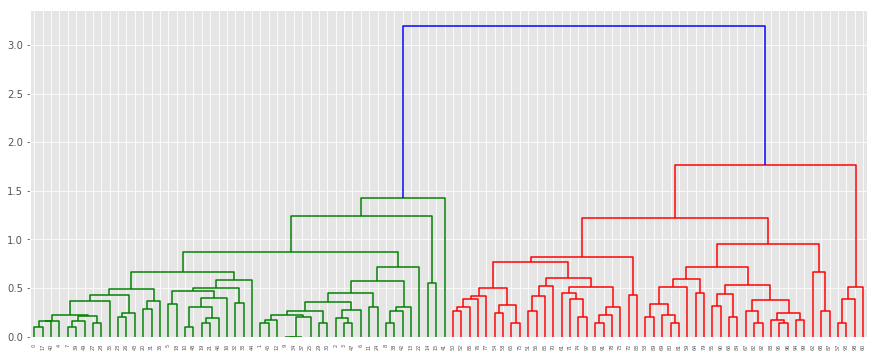

In [130]:
iris = datasets.load_iris()
x_iris = iris.data[:100]


from scipy.cluster.hierarchy import fcluster
model = Clustering(x_iris,2,linkage='average')
tic = time()
model.fit()
print time() - tic
pl.figure(figsize=(15, 6))

dend = dendrogram(model.Z)

In [5]:
%%timeit
model = Clustering(x_iris,k=2,linkage='single')
model.fit()

100 loops, best of 3: 7.02 ms per loop


In [6]:
%%timeit
Z = linkage(x_iris, method='average', metric='euclidean')

1000 loops, best of 3: 279 µs per loop


Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

(100L, 4L)


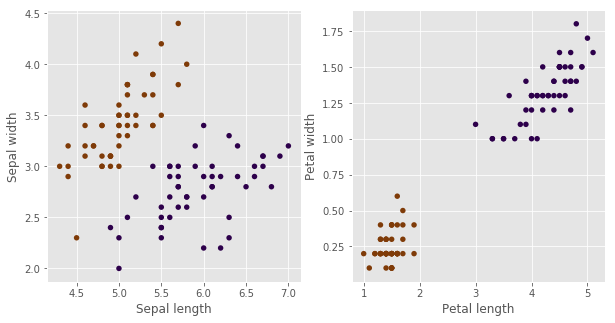

In [131]:
iris = ds.load_iris()
x_iris = iris.data[:100]
model = Clustering(x_iris,k=2,linkage='average')

y_iris = model.fit_predict() 

print x_iris.shape
pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()



Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

In [132]:
pred_iris = Clustering(x_iris,k=2,linkage='single')
pred_iris = pred_iris.fit_predict()
print "Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris)

Adjusted Rand index for iris is: 1.00


Выбрать и реализовать критерий качества, на основании которого будут подбираться параметры модели. Варианты критериев:
- Инерция (сумма квадратов расстояний от каждой из точек до ближайшего к этой точке центроида)
- Средний диаметр (максимальное расстояние между точками в кластере) или радиус (расстояние от центроида до самой дальней от него точки в кластере)
- Sihouette

**Критерий качества необходимо выбрать таким образом, чтобы он подходил для реализованного алгоритма**

In [133]:
## Задание 2
def quality(x, y):
    return smt.silhouette_score(x,y)

Применим критерий для выбора параметров алгоритма. Предлагается изменить следующий код таким образом, чтобы кластеризация вызывалась с верным набором параметров. На графике можно будет увидеть зависимость критерия от параметров алгоритма. Необходимо выбрать оптимальные значения этих параметров.

Single linkage:   0.736936816023 num clusters:   2
Complete linkage:   0.736936816023 num clusters:   2
Average linkage:   0.736936816023 num clusters:   2


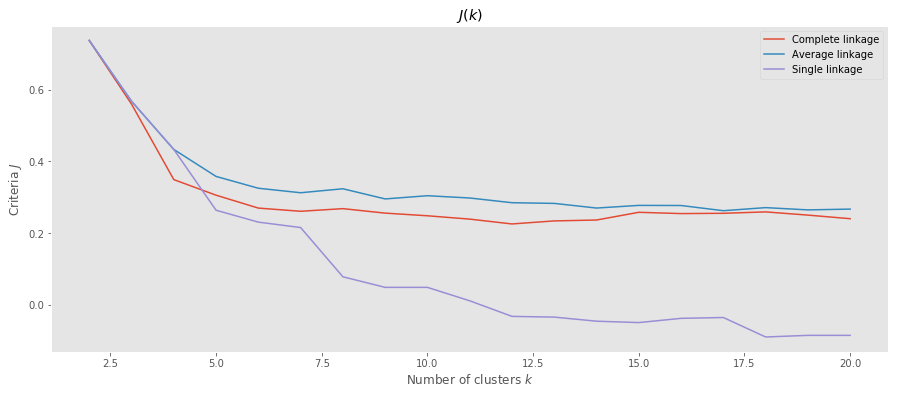

In [134]:
ks = range(2, 21)
criteria_single = np.zeros(len(ks))
criteria_complete = np.zeros(len(ks))
criteria_average = np.zeros(len(ks))

for i, k in enumerate(ks):
    cls = Clustering(x_iris,k,'single')
    y = cls.fit_predict()
    criteria_single[i] = quality(x_iris, y)
for i, k in enumerate(ks):
    cls = Clustering(x_iris,k,'complete')
    y = cls.fit_predict()
    criteria_complete[i] = quality(x_iris, y)
for i, k in enumerate(ks):
    cls = Clustering(x_iris,k,'average')
    y = cls.fit_predict()
    criteria_average[i] = quality(x_iris, y)

print 'Single linkage:  ', np.max(criteria_single), 'num clusters:  ', np.argmax(criteria_single) + 2 
print 'Complete linkage:  ', np.max(criteria_complete), 'num clusters:  ', np.argmax(criteria_complete) + 2 
print 'Average linkage:  ', np.max(criteria_average), 'num clusters:  ', np.argmax(criteria_average) + 2 

pl.figure(figsize=(15, 6))
pl.plot(ks, criteria_complete, label='Complete linkage')
pl.plot(ks, criteria_average, label='Average linkage')
pl.plot(ks, criteria_single, label='Single linkage')
pl.legend()
pl.title("$J(k)$")
pl.ylabel("Criteria $J$")
pl.xlabel("Number of clusters $k$")
pl.grid()
pl.show()  


In [135]:
## Задание 3
from collections import Counter
df = pd.read_csv('WDIData.csv', sep=',')
del df['Unnamed: 61']
df = df.dropna(axis=1,how='all')
df.columns= df.columns.map(lambda colname: colname.replace(' ', '_'))
countries = Counter(df['Country_Name']).keys()
countries.sort()
X = np.array([df[df.Country_Name == country]['2014'] for country in countries])
real_data = pd.DataFrame(data=X,index=countries,columns=df.loc[0:1550]['Indicator_Name'])
real_data = real_data.fillna(real_data.mean())
real_data = real_data.dropna(axis=1,how='any')
real_data 

Indicator_Name,Access to clean fuels and technologies for cooking (% of population),Access to electricity (% of population),"Access to electricity, rural (% of rural population)","Access to electricity, urban (% of urban population)",Account (% age 15+) [ts],Account at a financial institution (% age 15+),"Account at a financial institution, female (% age 15+)","Account at a financial institution, income, poorest 40% (% ages 15+)","Account at a financial institution, income, richest 60% (% ages 15+)","Account at a financial institution, male (% age 15+)",...,Wholesale price index (2010 = 100),"Women participating in the three decisions (own health care, major household purchases, and visiting family) (% of women age 15-49)",Women who believe a husband is justified in beating his wife (any of five reasons) (%),Women who believe a husband is justified in beating his wife when she argues with him (%),Women who believe a husband is justified in beating his wife when she burns the food (%),Women who believe a husband is justified in beating his wife when she goes out without telling him (%),Women who believe a husband is justified in beating his wife when she neglects the children (%),Women who believe a husband is justified in beating his wife when she refuses sex with him (%),Women who were first married by age 18 (% of women ages 20-24),Women's share of population ages 15+ living with HIV (%)
Afghanistan,17.305714,89.500000,87.800000,98.700000,9.961000,9.961000,3.812426,6.619139,12.203800,15.784670,...,117.004708,50.15,28.314815,27.48,12.29,25.77,30.56,20.19,32.800,28.522573
Albania,67.078662,100.000000,100.000000,100.000000,37.986350,37.986350,33.594230,23.406620,48.424090,42.519690,...,117.004708,50.15,28.314815,27.48,12.29,25.77,30.56,20.19,26.015,29.829357
Algeria,99.990000,100.000000,99.625305,100.000000,50.475790,50.475790,40.070960,36.676490,60.853890,60.909080,...,106.122977,50.15,28.314815,27.48,12.29,25.77,30.56,20.19,26.015,45.744283
American Samoa,63.295907,81.811640,75.178808,90.476124,54.810056,53.336536,50.621365,46.262227,58.140728,55.976585,...,117.004708,50.15,28.314815,27.48,12.29,25.77,30.56,20.19,26.015,42.258368
Andorra,100.000000,100.000000,100.000000,100.000000,54.810056,53.336536,50.621365,46.262227,58.140728,55.976585,...,117.004708,50.15,28.314815,27.48,12.29,25.77,30.56,20.19,26.015,42.258368
Angola,47.648150,32.000000,3.000000,51.000000,29.318120,29.318120,22.331650,12.895380,40.455550,36.132130,...,117.004708,50.15,28.314815,27.48,12.29,25.77,30.56,20.19,26.015,59.431870
Antigua and Barbuda,99.990000,96.442986,100.000000,85.295711,54.810056,53.336536,50.621365,46.262227,58.140728,55.976585,...,117.004708,50.15,28.314815,27.48,12.29,25.77,30.56,20.19,26.015,42.258368
Arab World,85.244971,88.039125,77.407269,96.088596,54.810056,53.336536,50.621365,46.262227,58.140728,55.976585,...,117.004708,50.15,28.314815,27.48,12.29,25.77,30.56,20.19,26.015,40.550804
Argentina,99.857594,100.000000,75.178808,90.476124,50.197300,50.197300,50.852360,44.363100,54.103210,49.458960,...,187.771397,50.15,28.314815,27.48,12.29,25.77,30.56,20.19,26.015,32.651164
Armenia,99.971231,100.000000,100.000000,100.000000,17.669070,17.239960,14.344120,10.865060,21.804490,20.657130,...,130.936571,50.15,28.314815,27.48,12.29,25.77,30.56,20.19,26.015,28.472567


65.8180000782


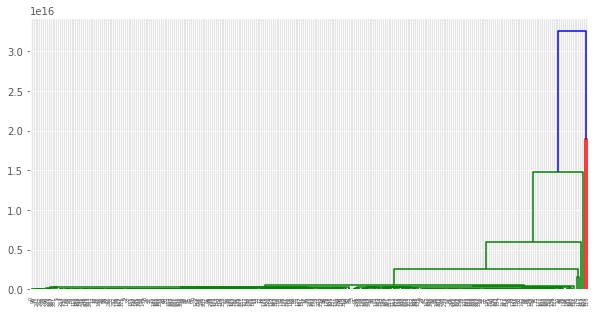

In [137]:
from time import time
from scipy.cluster.hierarchy import fcluster
data = real_data.iloc[:,1:].values
model = Clustering(data,2,linkage='average')
model.fit()
plt.figure(figsize=(10, 5))
dend = dendrogram(model.Z)

Single linkage:   0.979264111223 num clusters:   2
Complete linkage:   0.979264111223 num clusters:   2
Average linkage:   0.979264111223 num clusters:   2


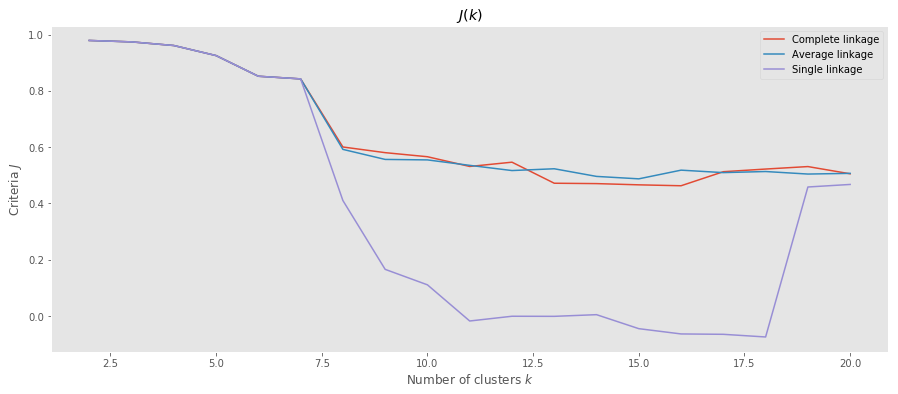

In [115]:
ks = range(2, 21)
criteria_single = np.zeros(len(ks))
criteria_complete = np.zeros(len(ks))
criteria_average = np.zeros(len(ks))

for i, k in enumerate(ks):
    cls = Clustering(data,k,'single')
    y = cls.fit_predict()
    criteria_single[i] = quality(data, y)
for i, k in enumerate(ks):
    cls = Clustering(data,k,'complete')
    y = cls.fit_predict()
    criteria_complete[i] = quality(data, y)
for i, k in enumerate(ks):
    cls = Clustering(data,k,'average')
    y = cls.fit_predict()
    criteria_average[i] = quality(data, y)

print 'Single linkage:  ', np.max(criteria_single), 'num clusters:  ', np.argmax(criteria_single) + 2 
print 'Complete linkage:  ', np.max(criteria_complete), 'num clusters:  ', np.argmax(criteria_complete) + 2 
print 'Average linkage:  ', np.max(criteria_average), 'num clusters:  ', np.argmax(criteria_average) + 2 

pl.figure(figsize=(15, 6))
pl.plot(ks, criteria_complete, label='Complete linkage')
pl.plot(ks, criteria_average, label='Average linkage')
pl.plot(ks, criteria_single, label='Single linkage')
pl.legend()
pl.title("$J(k)$")
pl.ylabel("Criteria $J$")
pl.xlabel("Number of clusters $k$")
pl.grid()
pl.show()  


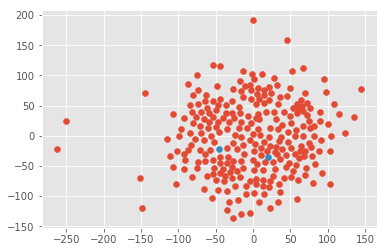

In [117]:
from sklearn.manifold import TSNE
model = Clustering(data,2,linkage='comlete')
labels = model.fit_predict()
X_embedded = TSNE(n_components=2).fit_transform(data)
plt.scatter(X_embedded[labels==1,0],X_embedded[labels==1,1])
plt.scatter(X_embedded[labels==2,0],X_embedded[labels==2,1])

In [102]:
labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

[[ nan  nan  nan ...,  nan  nan  nan]]


In [ ]:
## Задание 4

Поздравляем, Вы завершили домашние задания по модулю "Алгоритмы кластеризации". Надеемся, что это было интересно.